Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
  0% 0.00/98.8M [00:00<?, ?B/s]
100% 98.8M/98.8M [00:00<00:00, 1.05GB/s]
Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1129s 408ms/step - accuracy: 0.9336 - loss: 0.2426 - val_accuracy: 0.9745 - val_loss: 0.0894 - learning_rate: 5.0000e-04
Epoch 2/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1124s 411ms/step - accuracy: 0.9744 - loss: 0.0910 - val_accuracy: 0.9781 - val_loss: 0.0771 - learning_rate: 5.0000e-04
Epoch 3/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1157s 409ms/step - accuracy: 0.9798 - loss: 0.0718 - val_accuracy: 0.9816 - val_loss: 0.0705 - learning_rate: 5.0000e-04
Epoch 4/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1161s 409ms/step - accuracy: 0.9823 - loss: 0.0602 - val_accuracy: 0.9813 - val_loss: 0.0692 - learning_rate: 5.0000e-04
Epoch 5/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1159s 407ms/step - accuracy: 0.9836 - loss: 0.0537 - val_accuracy: 0.9820 - val_loss: 0.0654 - learning_rate: 5.0000e-04
Epoch 6/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1153s 404ms/step - accuracy: 0.9857 - loss: 0.0496 - val_accuracy: 0.9834 - val_loss: 0.0662 - learning_rate: 5.0000e-04
Epoch 7/15
2737/2737 ━

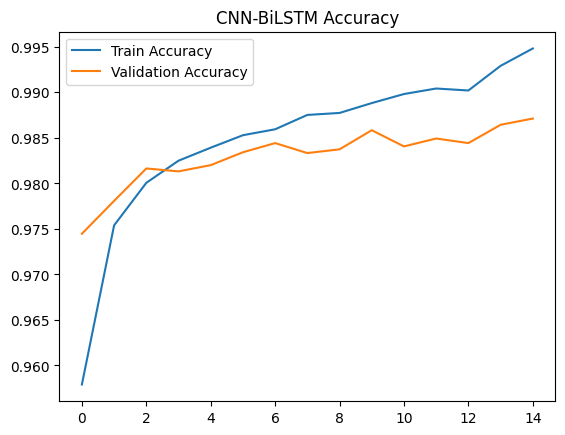


Classification Report:
              precision    recall  f1-score   support

         0.0     0.9906    0.9967    0.9936     18118
         1.0     0.9287    0.7734    0.8440       556
         2.0     0.9741    0.9599    0.9670      1448
         3.0     0.8395    0.8395    0.8395       162
         4.0     0.9913    0.9925    0.9919      1608

    accuracy                         0.9871     21892
   macro avg     0.9448    0.9124    0.9272     21892
weighted avg     0.9868    0.9871    0.9868     21892


Confusion Matrix:
[[18058    29    15     6    10]
 [  115   430     9     1     1]
 [   33     3  1390    19     3]
 [   15     1    10   136     0]
 [    9     0     3     0  1596]]

Per-Class Accuracy:
Class 0: 0.9967
Class 1: 0.7734
Class 2: 0.9599
Class 3: 0.8395
Class 4: 0.9925


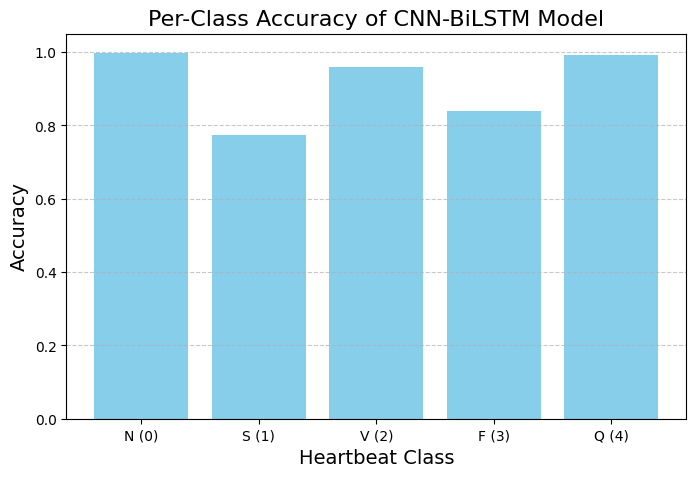

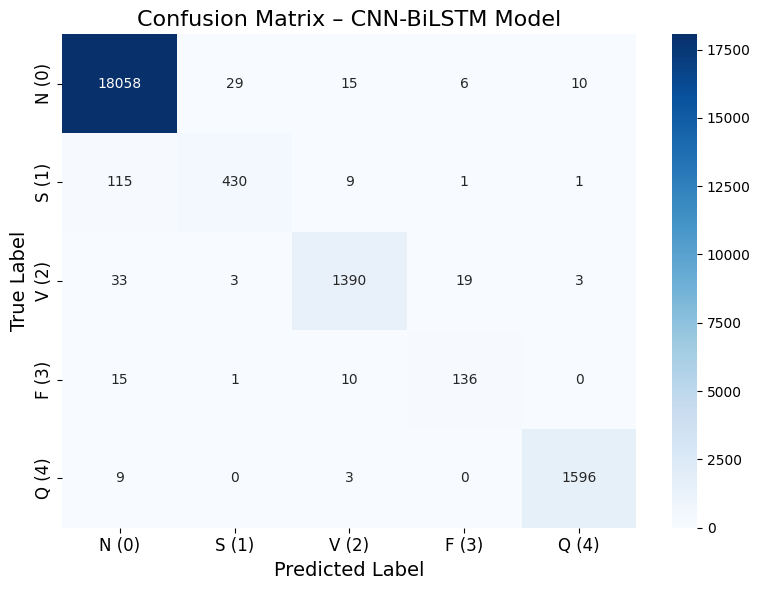

In [1]:
#  Install Kaggle & Download Dataset
!pip install kaggle -q
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip

#  Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

#  Load Dataset
df = pd.read_csv("mitbih_train.csv", header=None)
df_test = pd.read_csv("mitbih_test.csv", header=None)

X_train = df.iloc[:, :-1].values
y_train = df.iloc[:, -1].values
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

#  Normalize Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#  Define Optimized CNN-BiLSTM Model
model = Sequential([
    # CNN Layers
    Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(512, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # LSTM Layers
    Bidirectional(LSTM(128, return_sequences=True)),  # Bidirectional for better feature learning
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.3),

    # Fully Connected Layers
    Dense(512, activation='relu'),  # Increased Dense layer neurons
    Dropout(0.5),
    Dense(5, activation='softmax')
])

#  Compile Model with Optimizer & Gradient Clipping
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)  # Clipnorm prevents exploding gradients
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#  Train Model (50+ epochs for maximum accuracy)
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

#  Evaluate Model
cnn_bilstm_pred = np.argmax(model.predict(X_test), axis=1)
cnn_bilstm_acc = np.mean(cnn_bilstm_pred == y_test)
print(f"CNN-BiLSTM Test Accuracy: {cnn_bilstm_acc:.4f}")

#  Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("CNN-BiLSTM Accuracy")
plt.show()



from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, cnn_bilstm_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, cnn_bilstm_pred)
print("\nConfusion Matrix:")
print(cm)

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc:.4f}")

# Plot Per-Class Accuracy
plt.figure(figsize=(8, 5))
classes = ['N (0)', 'S (1)', 'V (2)', 'F (3)', 'Q (4)']
plt.bar(classes, class_accuracy, color='skyblue')
plt.ylim(0, 1.05)
plt.title('Per-Class Accuracy of CNN-BiLSTM Model', fontsize=16)
plt.xlabel('Heartbeat Class', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix – CNN-BiLSTM Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()